# VM: Deep Learning mit Python

*Group: Leo Giesen, Johannes Kauffmann*

Case Study: Create deep learning model to predict Land Use and Land Cover data drom satellite pictures.

In [30]:
# Imports

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import calendar
import os
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

**Define class names and channel names**

In [2]:
# Class names

class_names = {
    0: "No Data", 
    1: "Cultivated Land",
    2: "Forest",
    3: "Grassland",
    4: "Shrubland",
    5: "Water",
    6: "Wetlands",
    7: "Tundra",
    8: "Artificial Surface",
    9: "Bareland",
    10: "Snow and Ice"
}

In [3]:
# Channel names

channel_names = {
    1: "Red",
    2: "Green",
    3: "Blue",
    4: "NIR 1",
    5: "NIR 2",
    6: "NIR 3"
}

**Loading data**

In [4]:
data = np.load('../data/train.npz')
bands = data['bands'] # data: 10.000 patches, each for twelve months and with six channels. Resolution: 33x33 pixels
lulc = data['lulc'] # labels for central pixel of patches (Land Use and Land Cover)
#print(bands.shape)
#print(lulc.shape)

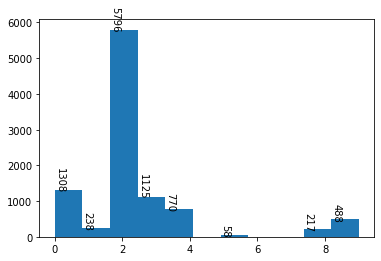

In [28]:
# show absolute number of classes
# code adapted from https://stackoverflow.com/a/66001380
data = lulc
density, bins, _ = plt.hist(data, bins=11)
count, _ = np.histogram(data, bins)
for x,y,num in zip(bins, density, count):
    if num != 0:
        plt.text(x, y+0.05, num, fontsize=10, rotation=-90)

Realization: Class 2 is really over-represented.

Channels from patch no. 250
Central pixel is labeled as Cultivated Land


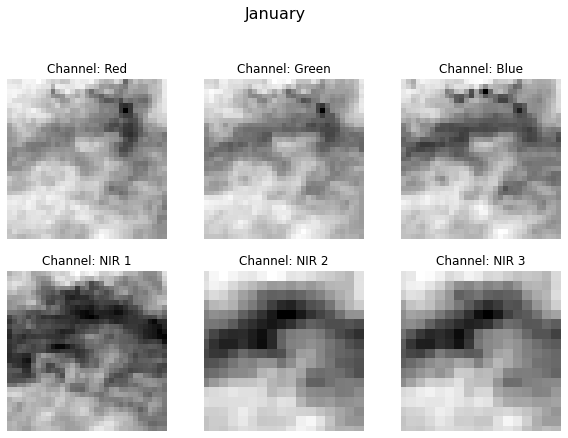

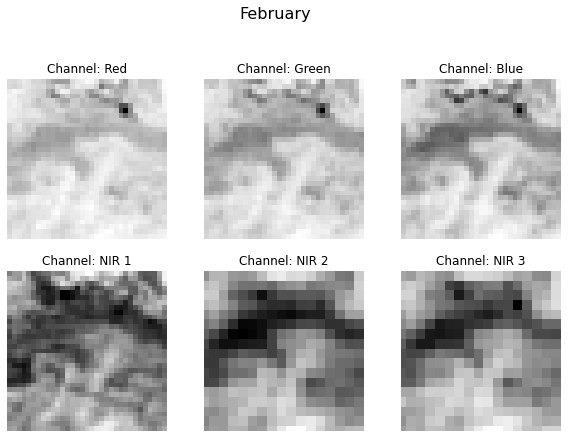

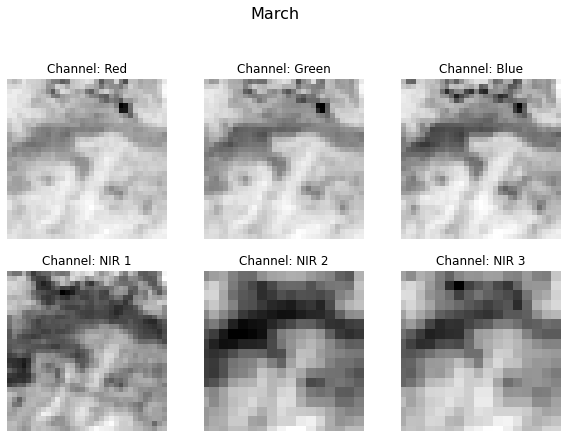

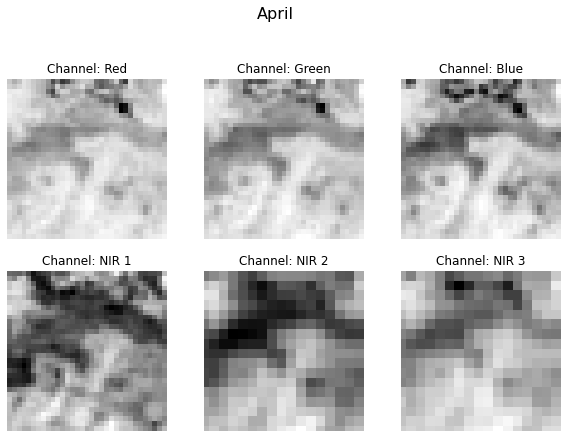

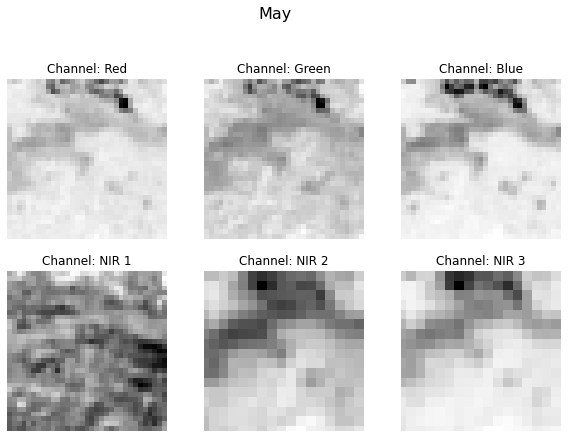

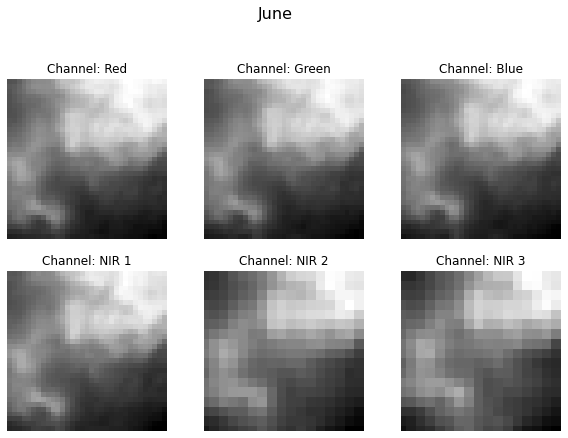

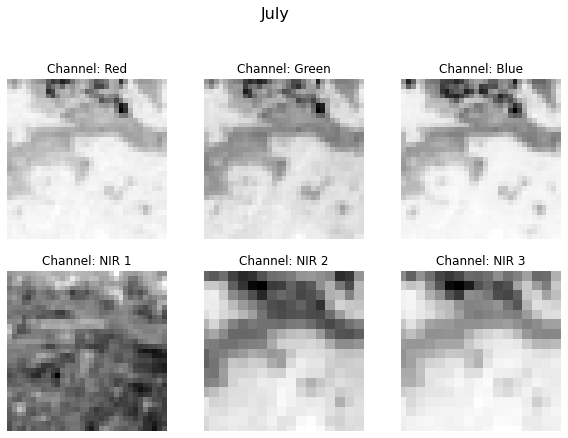

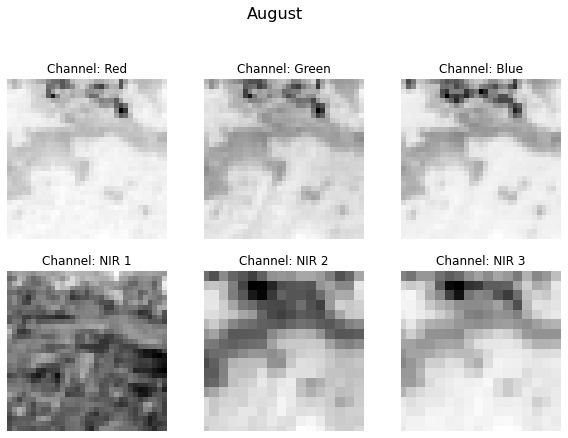

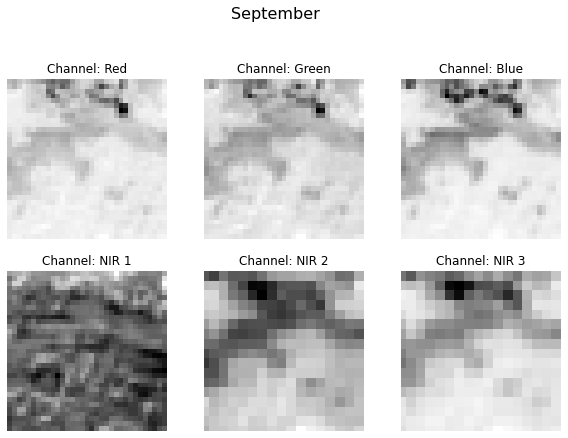

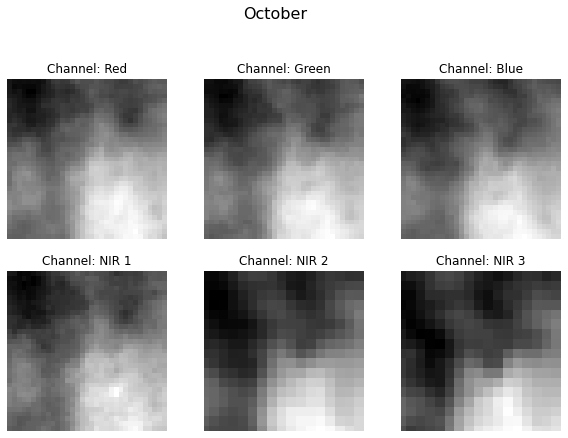

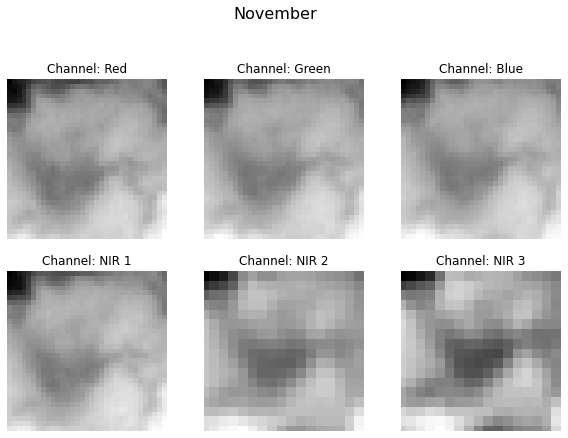

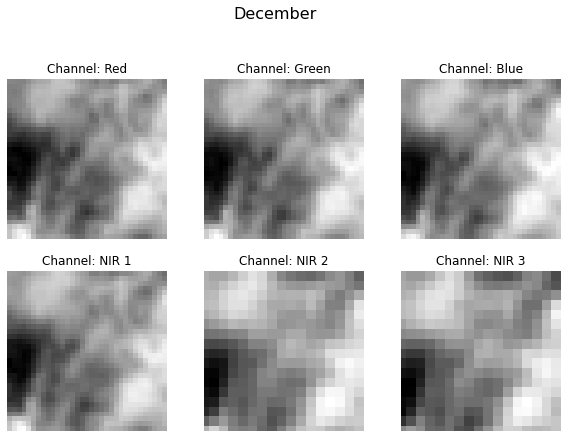

In [5]:
# Show some images

patch = 250 # patch number

print("Channels from patch no. " + str(patch))
print("Central pixel is labeled as " + class_names[lulc[patch]])

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands[patch, month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

**Preprocessing**

**Oversampling**
Duplicating samples from the minority class

In [35]:
# from imblearn.over_sampling import SMOTE
# X = bands
# y = lulc
# ros = SMOTE()
# X_ros, y_ros = ros.fit_resample(X, y)

**Padding**

In [ ]:
#X_pad = np.pad(X[, ((16,16),(16,16)), 'constant')
#y_pad = np.pad(y, ((16,16),(16,16)), 'constant')

In [6]:
# Generating test, validation and training sets
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20)

**Build the 3D CNN Model**

adapted by: https://towardsdatascience.com/step-by-step-implementation-3d-convolutional-neural-network-in-keras-12efbdd7b130

In [7]:
model = Sequential() # sequential model
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
model.add(Dense(256, activation=tf.keras.layers.LeakyReLU(alpha=0.1), kernel_initializer='he_uniform')) #leaky relu and not standard one
model.add(Dense(11, activation='softmax')) # number of outputs, in our case eleven different classes

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 31, 31, 32)    5216      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 15, 15, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 15, 15, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 5, 15, 15, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 3, 13, 13, 64)     55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 1, 6, 6, 64)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 6, 6, 64)       2

In [8]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
126/200 [=================>............] - ETA: 2:02 - loss: 2.0315 - accuracy: 0.4917

KeyboardInterrupt: 

In [37]:
#model.save('../modelels/trainingData_5Epochs.h5') # save model in root directory
model = keras.models.load_model('../modelels/trainingData_5Epochs.h5')

**Evaluation**

63/63 [==============================] - 30s 471ms/step - loss: 0.8801 - accuracy: 0.6990
Predictions of Channel Red in January for nine test pictures:


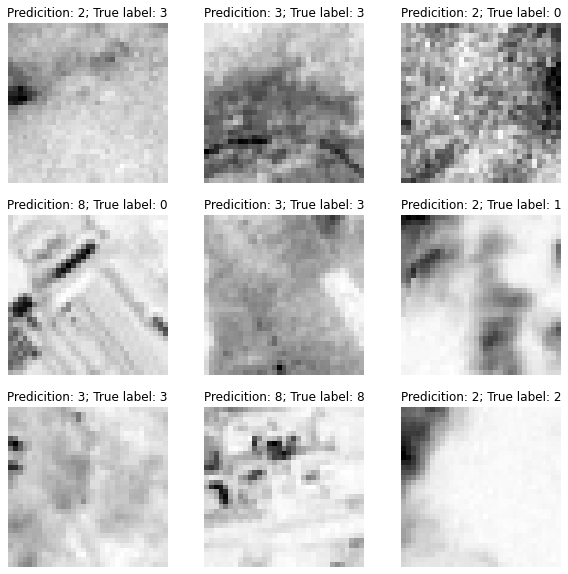

In [42]:
# Calculate loss and accuracy
model.evaluate(X_test, y_test)
#63/63 [==============================] - 18s 288ms/step - loss: 0.8801 - accuracy: 0.6990

# Predicitions with test-set
y_pred = model.predict_classes(X_test)
plt.figure(figsize=(10, 10))
print("Predictions of Channel Red in January for nine test pictures:")
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(X_test[i, 0, :, :, 0], cmap = plt.cm.binary)
  plt.title("Predicition: " + str(y_pred[i]) + "; True label: " + str(y_test[i]))
  plt.axis("off")

NameError: name 'history' is not defined

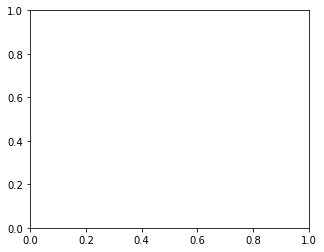

In [14]:
#Plot accuracy and loss of train and val set
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(history.history['accuracy'], color="green")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title("Accuracy", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'], color="red",)
plt.plot(history.history['val_loss'], color="orange")
plt.title("Loss", fontsize=16)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

**Testing on Public Test Set**

In [48]:
data_public_test = np.load('../data/public_test.npz') # load public test set
bands_public_test = data_public_test['bands'] # extract only layer called 'bands'
bands_public_test.shape

(12, 500, 500, 6)

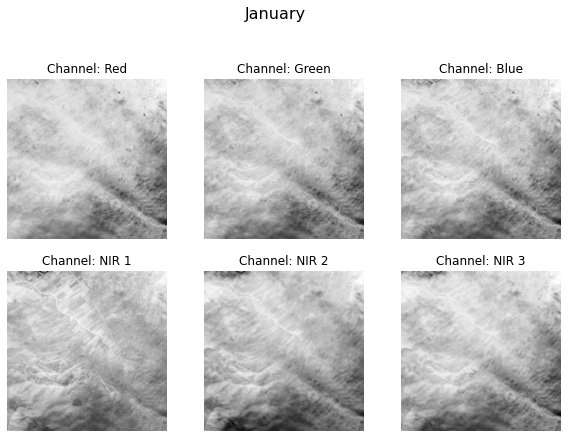

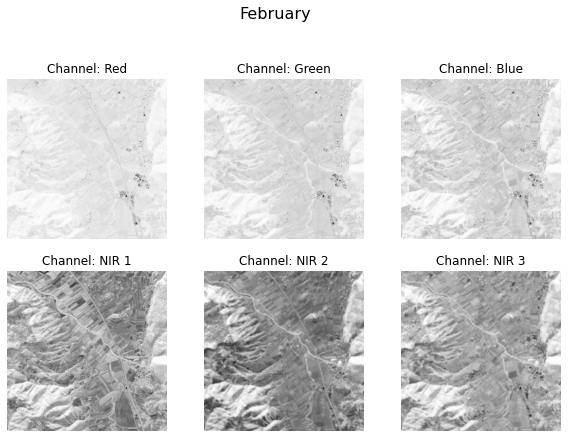

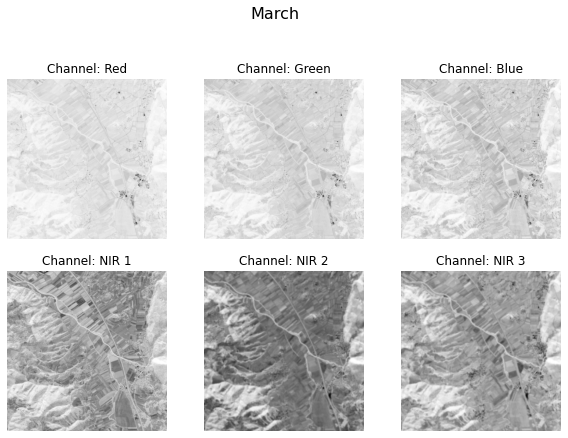

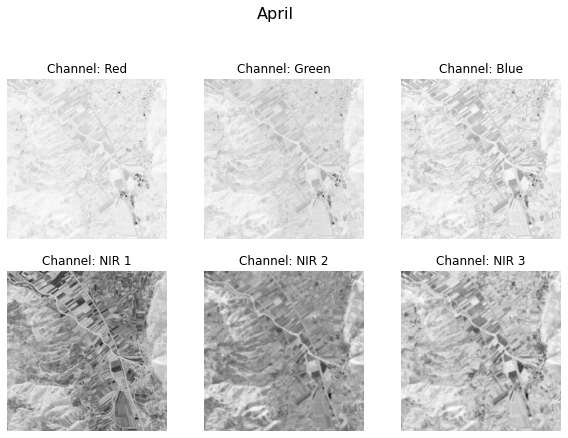

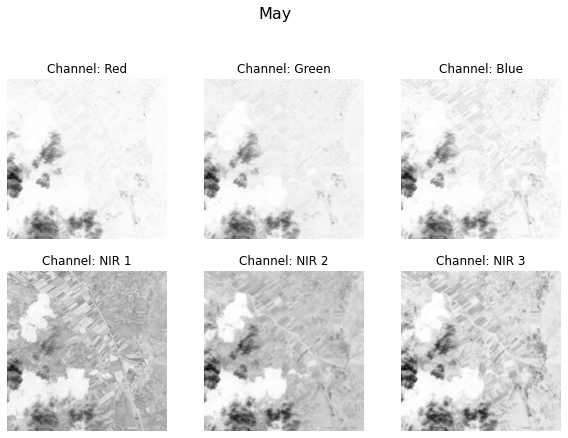

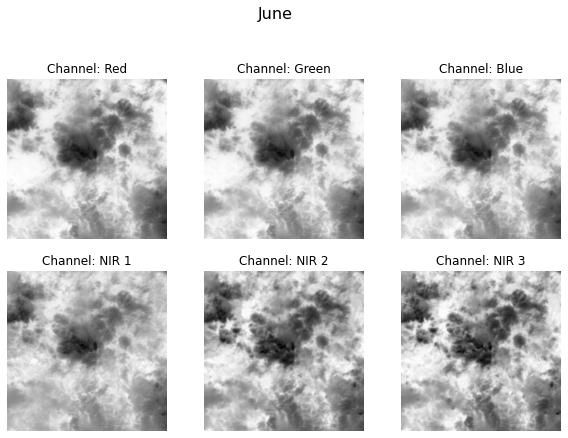

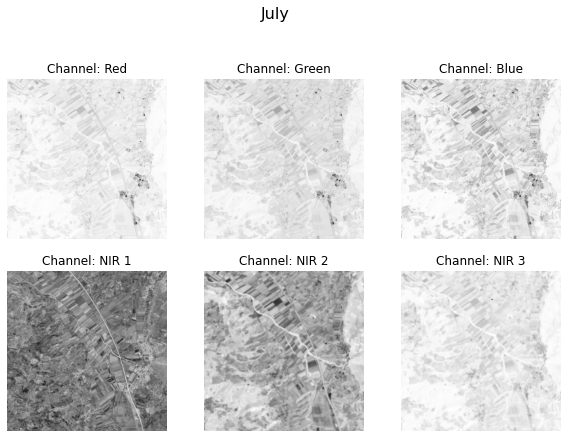

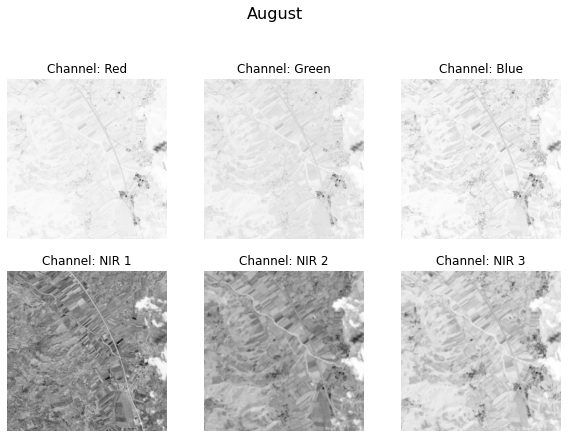

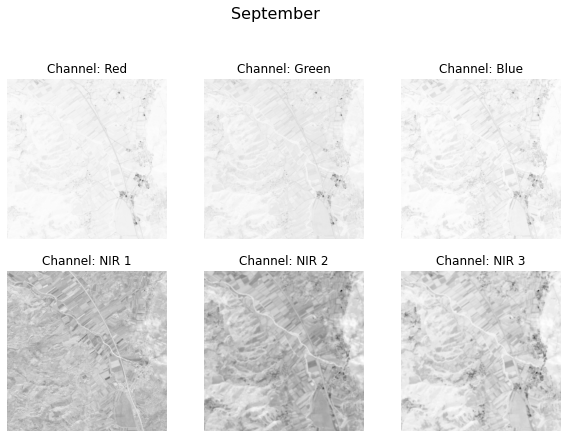

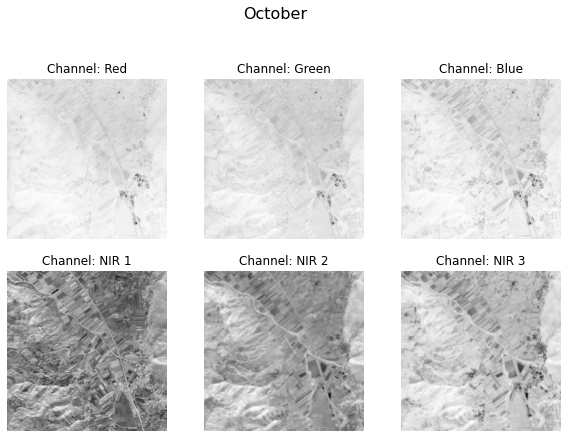

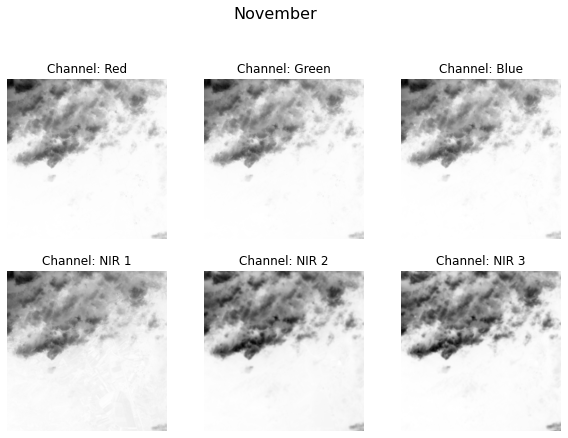

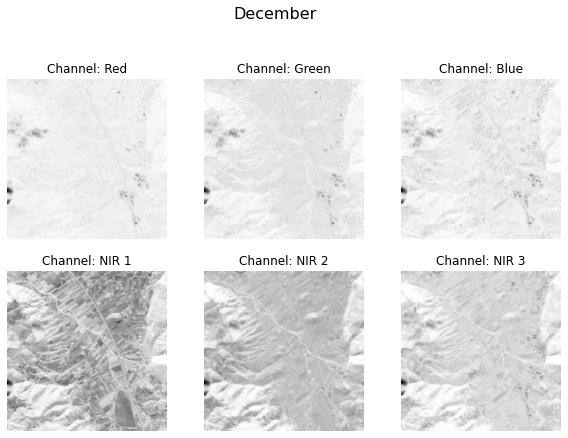

In [13]:
# Show all 12 monthly images of the public test set

for month in range(12):
    plt.figure(figsize=(10, 10))
    for channel in range(6): #show all six channels
        ax = plt.subplot(3, 3, channel+1)
        image = bands_public_test[month, :, :, channel]
        plt.imshow(image, cmap = plt.cm.binary)
        plt.title("Channel: " + channel_names[channel+1])
        plt.suptitle(calendar.month_name[month+1], size=16)
        plt.axis("off")

In [ ]:
# add one dimension to be able feeding our model

bands_public_test = np.expand_dims(bands_public_test , 0)
bands_public_test.shape

**Naive sliding window approach**

Iterate the model over the whole public test image with stepsize one.

In [ ]:
x_coord = 32
y_coord = 32

current_cutout = bands_public_test[:, :, 0:x_coord, 0:y_coord , :6]
current_cutout.shape
y_pred_public_test = np.zeros(shape=(466, 466, 1))

for i in range(466):
    x_coord += 1
    for j in range(466):
        y_coord += 1
        y_pred = model.predict_classes(current_cutout)
        y_pred_public_test[i][j] = y_pred[0]

plt.imshow(y_pred_public_test, cmap = plt.cm.binary)

In [59]:
plt.imsave('public_test_pred.png', y_pred_public_test)

# import tensorflow_hub as hub


# base_model = hub.load("https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1")
# model = tf.keras.Sequential([
#   base_model, Dense(11, activation='softmax')])